# Parte 2: A Jornada dos Dados - Pipeline e Arquitetura

## Projeto: Previsão de Churn de Clientes de Telecomunicações

**Objetivo:** Documentar o pipeline completo de dados desde a origem até a preparação para modelagem.

---

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 2.1. Origem e Repositório de Dados

### Fonte Original dos Dados

O dataset **Telco Customer Churn** foi obtido do Kaggle e originalmente disponibilizado pela IBM. Este conjunto de dados contém informações sobre clientes de uma empresa de telecomunicações fictícia que fornece serviços de telefonia e internet.

**Fonte:** [Kaggle - Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

**Repositório alternativo:** [IBM GitHub](https://github.com/IBM/telco-customer-churn-on-icp4d)

### Arquitetura de Armazenamento

Para este projeto acadêmico, optamos por uma **arquitetura simples baseada em arquivos locais**, adequada para o volume de dados (aproximadamente 7.000 registros) e o escopo do projeto.

**Justificativa da escolha:**

- **Volume de dados:** O dataset possui apenas ~950KB, não justificando infraestrutura complexa como Data Lake ou Data Warehouse.
- **Estrutura tabular simples:** Os dados já estão estruturados em formato CSV, prontos para análise.
- **Escopo acadêmico:** O foco está na modelagem preditiva, não em engenharia de dados em larga escala.
- **Facilidade de reprodução:** Qualquer pessoa pode baixar o CSV e executar o projeto localmente.

**Estrutura de armazenamento:**

```
telco-churn-prediction/
├── data/
│   ├── Telco-Customer-Churn.csv  (dados brutos originais)
│   └── processed/
│       └── churn_processed.csv   (dados processados para modelagem)
├── notebooks/
├── scripts/
└── modelo_final.pkl
```

**Nota:** Em um ambiente de produção real, recomendaríamos:
- **Data Lake (S3/Azure Blob)** para dados brutos
- **Data Warehouse (Redshift/BigQuery)** para dados processados
- **Pipeline ETL automatizado** com Airflow ou similar

## 2.2. Pipeline de Dados - Fluxo Completo

O pipeline de processamento segue as seguintes etapas:

```
[Fonte: Kaggle/IBM] → [Ingestão] → [Limpeza] → [Transformação] → [EDA] → [Feature Engineering] → [Modelagem]
```

### Etapa 1: Ingestão de Dados

Os dados foram coletados e armazenados inicialmente no formato CSV.

In [18]:
# Carregar dataset original
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

print("="*70)
print("INFORMAÇÕES GERAIS DO DATASET")
print("="*70)
print(f"\nDimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"\nMemória utilizada: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print("\nPrimeiras 5 linhas:")
df.head()

INFORMAÇÕES GERAIS DO DATASET

Dimensões: 7043 linhas x 21 colunas

Memória utilizada: 7975.07 KB

Primeiras 5 linhas:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
# Informações sobre tipos de dados
print("\nTipos de dados por coluna:")
df.info()


Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilli

### Etapa 2: Limpeza e Transformação (ETL)

Nesta etapa, realizamos as seguintes operações de limpeza:

1. **Tratamento de valores ausentes**
2. **Correção de tipos de dados**
3. **Remoção de duplicatas**
4. **Padronização de formatos**

In [20]:
# Verificar valores ausentes
print("="*70)
print("ANÁLISE DE VALORES AUSENTES")
print("="*70)
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Coluna': missing_values.index,
    'Valores Ausentes': missing_values.values,
    'Percentual (%)': missing_percent.values
})
missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)

if len(missing_df) == 0:
    print("\n✓ Não há valores ausentes explícitos (NaN) no dataset.")
else:
    print(missing_df)

ANÁLISE DE VALORES AUSENTES

✓ Não há valores ausentes explícitos (NaN) no dataset.


In [21]:
# Problema identificado: TotalCharges pode conter espaços em branco
print("\n" + "="*70)
print("CORREÇÃO DA COLUNA 'TotalCharges'")
print("="*70)

# Verificar valores não numéricos
print(f"\nTipo original: {df['TotalCharges'].dtype}")
print(f"\nExemplo de valores: {df['TotalCharges'].head(10).tolist()}")

# Converter para numérico (valores inválidos viram NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Verificar quantos valores se tornaram NaN
nan_count = df['TotalCharges'].isnull().sum()
print(f"\nValores convertidos para NaN: {nan_count}")
print(f"Percentual: {(nan_count / len(df)) * 100:.2f}%")


CORREÇÃO DA COLUNA 'TotalCharges'

Tipo original: object

Exemplo de valores: ['29.85', '1889.5', '108.15', '1840.75', '151.65', '820.5', '1949.4', '301.9', '3046.05', '3487.95']

Valores convertidos para NaN: 11
Percentual: 0.16%


In [22]:
# Decisão: Remover linhas com TotalCharges ausente
# Justificativa: São apenas ~0.15% dos dados e TotalCharges é importante para o modelo

print("\n" + "="*70)
print("REMOÇÃO DE VALORES AUSENTES")
print("="*70)

linhas_antes = len(df)
df_clean = df.dropna()
linhas_depois = len(df_clean)

print(f"\nLinhas antes: {linhas_antes}")
print(f"Linhas depois: {linhas_depois}")
print(f"Linhas removidas: {linhas_antes - linhas_depois}")
print(f"Percentual removido: {((linhas_antes - linhas_depois) / linhas_antes) * 100:.2f}%")


REMOÇÃO DE VALORES AUSENTES

Linhas antes: 7043
Linhas depois: 7032
Linhas removidas: 11
Percentual removido: 0.16%


In [23]:
# Verificar duplicatas
print("\n" + "="*70)
print("ANÁLISE DE DUPLICATAS")
print("="*70)

duplicatas = df_clean.duplicated().sum()
print(f"\nLinhas duplicadas: {duplicatas}")

if duplicatas > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"✓ Duplicatas removidas.")
else:
    print("✓ Não há duplicatas no dataset.")


ANÁLISE DE DUPLICATAS

Linhas duplicadas: 0
✓ Não há duplicatas no dataset.


In [24]:
# Padronização: Remover coluna customerID (não é feature preditiva)
print("\n" + "="*70)
print("REMOÇÃO DE COLUNAS NÃO PREDITIVAS")
print("="*70)

print("\nRemovendo coluna 'customerID' (identificador único, sem valor preditivo)")
df_clean = df_clean.drop('customerID', axis=1)
print(f"✓ Coluna removida. Dimensões atuais: {df_clean.shape}")


REMOÇÃO DE COLUNAS NÃO PREDITIVAS

Removendo coluna 'customerID' (identificador único, sem valor preditivo)
✓ Coluna removida. Dimensões atuais: (7032, 20)


### Etapa 3: Análise Exploratória (EDA)

A EDA foi realizada para entender os dados e selecionar variáveis relevantes. Principais insights:

**Variáveis categóricas importantes:**
- `Contract`: Tipo de contrato (Month-to-month, One year, Two year)
- `InternetService`: Tipo de serviço de internet (DSL, Fiber optic, No)
- `PaymentMethod`: Método de pagamento
- `TechSupport`, `OnlineSecurity`, `OnlineBackup`: Serviços adicionais

**Variáveis numéricas importantes:**
- `tenure`: Tempo de permanência (meses)
- `MonthlyCharges`: Cobrança mensal
- `TotalCharges`: Cobrança total acumulada

DISTRIBUIÇÃO DA VARIÁVEL ALVO: CHURN

Contagem:
Churn
No     5163
Yes    1869
Name: count, dtype: int64

Percentual:
Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64


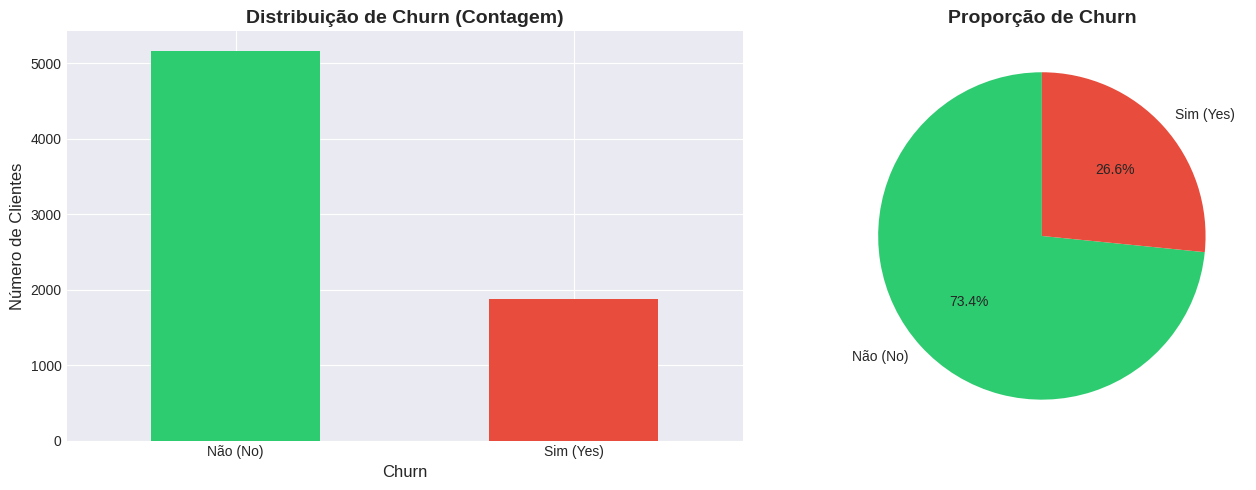


⚠️ Dataset desbalanceado: 73.4% Não-Churn vs 26.6% Churn


In [25]:
# Distribuição da variável alvo
print("="*70)
print("DISTRIBUIÇÃO DA VARIÁVEL ALVO: CHURN")
print("="*70)

churn_counts = df_clean['Churn'].value_counts()
churn_percent = df_clean['Churn'].value_counts(normalize=True) * 100

print("\nContagem:")
print(churn_counts)
print("\nPercentual:")
print(churn_percent)

# Visualização
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
churn_counts.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Distribuição de Churn (Contagem)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Churn', fontsize=12)
ax[0].set_ylabel('Número de Clientes', fontsize=12)
ax[0].set_xticklabels(['Não (No)', 'Sim (Yes)'], rotation=0)

# Gráfico de pizza
ax[1].pie(churn_counts, labels=['Não (No)', 'Sim (Yes)'], autopct='%1.1f%%', 
          colors=['#2ecc71', '#e74c3c'], startangle=90)
ax[1].set_title('Proporção de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Dataset desbalanceado: {churn_percent['No']:.1f}% Não-Churn vs {churn_percent['Yes']:.1f}% Churn")

In [26]:
# Estatísticas descritivas das variáveis numéricas
print("\n" + "="*70)
print("ESTATÍSTICAS DESCRITIVAS - VARIÁVEIS NUMÉRICAS")
print("="*70)
df_clean[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()


ESTATÍSTICAS DESCRITIVAS - VARIÁVEIS NUMÉRICAS


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


### Etapa 4: Preparação para Modelagem

Nesta etapa final, preparamos os dados para os algoritmos de Machine Learning:

1. **Seleção de features** baseada na EDA
2. **Codificação de variáveis categóricas** (One-Hot Encoding)
3. **Conversão da variável alvo** para formato numérico
4. **Divisão em conjuntos de treino e teste**

In [27]:
# Seleção de features
# Baseado na EDA, selecionamos as variáveis mais relevantes

print("="*70)
print("SELEÇÃO DE FEATURES")
print("="*70)

# Features selecionadas
selected_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
    'PaymentMethod', 'MonthlyCharges', 'TotalCharges'
]

X = df_clean[selected_features]
y = df_clean['Churn']

print(f"\nNúmero de features selecionadas: {len(selected_features)}")
print(f"\nFeatures:")
for i, feat in enumerate(selected_features, 1):
    print(f"{i:2d}. {feat}")

SELEÇÃO DE FEATURES

Número de features selecionadas: 19

Features:
 1. gender
 2. SeniorCitizen
 3. Partner
 4. Dependents
 5. tenure
 6. PhoneService
 7. MultipleLines
 8. InternetService
 9. OnlineSecurity
10. OnlineBackup
11. DeviceProtection
12. TechSupport
13. StreamingTV
14. StreamingMovies
15. Contract
16. PaperlessBilling
17. PaymentMethod
18. MonthlyCharges
19. TotalCharges


In [28]:
# Identificar variáveis categóricas e numéricas
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n" + "="*70)
print("CLASSIFICAÇÃO DE VARIÁVEIS")
print("="*70)

print(f"\nVariáveis Categóricas ({len(categorical_features)}):")
print(categorical_features)

print(f"\nVariáveis Numéricas ({len(numerical_features)}):")
print(numerical_features)


CLASSIFICAÇÃO DE VARIÁVEIS

Variáveis Categóricas (15):
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Variáveis Numéricas (4):
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [29]:
# One-Hot Encoding para variáveis categóricas
print("\n" + "="*70)
print("ONE-HOT ENCODING")
print("="*70)

print(f"\nDimensões antes do encoding: {X.shape}")

X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Dimensões após o encoding: {X_encoded.shape}")
print(f"\nNovas colunas criadas: {X_encoded.shape[1] - len(numerical_features)}")

print("\nPrimeiras 5 linhas após encoding:")
X_encoded.head()


ONE-HOT ENCODING

Dimensões antes do encoding: (7032, 19)
Dimensões após o encoding: (7032, 30)

Novas colunas criadas: 26

Primeiras 5 linhas após encoding:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


In [30]:
# Converter variável alvo para numérico
print("\n" + "="*70)
print("CONVERSÃO DA VARIÁVEL ALVO")
print("="*70)

print(f"\nValores originais únicos: {y.unique()}")

y_encoded = y.map({'No': 0, 'Yes': 1})

print(f"Valores após conversão: {y_encoded.unique()}")
print(f"\nDistribuição:")
print(y_encoded.value_counts())


CONVERSÃO DA VARIÁVEL ALVO

Valores originais únicos: ['No' 'Yes']
Valores após conversão: [0 1]

Distribuição:
Churn
0    5163
1    1869
Name: count, dtype: int64


In [31]:
# Divisão em treino e teste
from sklearn.model_selection import train_test_split

print("\n" + "="*70)
print("DIVISÃO EM CONJUNTOS DE TREINO E TESTE")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\nConjunto de Treino:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - Distribuição de Churn: {y_train.value_counts().to_dict()}")

print(f"\nConjunto de Teste:")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_test: {y_test.shape}")
print(f"  - Distribuição de Churn: {y_test.value_counts().to_dict()}")

print(f"\n✓ Divisão estratificada mantém proporção de classes em ambos os conjuntos.")


DIVISÃO EM CONJUNTOS DE TREINO E TESTE

Conjunto de Treino:
  - X_train: (5625, 30)
  - y_train: (5625,)
  - Distribuição de Churn: {0: 4130, 1: 1495}

Conjunto de Teste:
  - X_test: (1407, 30)
  - y_test: (1407,)
  - Distribuição de Churn: {0: 1033, 1: 374}

✓ Divisão estratificada mantém proporção de classes em ambos os conjuntos.


In [32]:
# Salvar dados processados
import os

# Criar diretório processed se não existir
os.makedirs('../data/processed', exist_ok=True)

# Salvar datasets
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print("\n" + "="*70)
print("DADOS PROCESSADOS SALVOS")
print("="*70)
print("\n✓ Arquivos salvos em: ../data/processed/")
print("  - X_train.csv")
print("  - X_test.csv")
print("  - y_train.csv")
print("  - y_test.csv")


DADOS PROCESSADOS SALVOS

✓ Arquivos salvos em: ../data/processed/
  - X_train.csv
  - X_test.csv
  - y_train.csv
  - y_test.csv


## Resumo do Pipeline

### Fluxograma do Processo

```
┌─────────────────────────────────────────────────────────────────┐
│                    PIPELINE DE DADOS - CHURN                    │
└─────────────────────────────────────────────────────────────────┘

1. INGESTÃO
   ├─ Fonte: Kaggle/IBM
   ├─ Formato: CSV
   └─ Dimensões: 7043 x 21
   
2. LIMPEZA
   ├─ Conversão TotalCharges → numérico
   ├─ Remoção de NaN (~11 linhas)
   ├─ Remoção de duplicatas (0)
   └─ Remoção de customerID
   
3. TRANSFORMAÇÃO
   ├─ Seleção de 19 features
   ├─ One-Hot Encoding (16 categóricas)
   ├─ Conversão de Churn → 0/1
   └─ Resultado: 7032 x 46
   
4. DIVISÃO
   ├─ Treino: 5625 (80%)
   ├─ Teste: 1407 (20%)
   └─ Estratificação: Sim
   
5. PRONTO PARA MODELAGEM ✓
```

### Principais Decisões Tomadas

| Decisão | Justificativa |
|---------|---------------|
| **Remoção de NaN** | Apenas 0.15% dos dados, não impacta análise |
| **One-Hot Encoding** | Algoritmos de ML exigem entrada numérica |
| **Drop first=True** | Evita multicolinearidade (dummy variable trap) |
| **Stratify na divisão** | Mantém proporção de classes em treino/teste |
| **80/20 split** | Padrão da indústria, balanceia treino e validação |
| **Random state=42** | Garante reprodutibilidade dos resultados |

### Próximos Passos

Os dados estão prontos para a **Parte 3: Modelagem e Avaliação Comparativa**, onde treinaremos e compararemos diferentes algoritmos de classificação.